In [1]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#import packages
import glob
import os
import numpy as np
import pickle
import platform
import math
from IPython.display import clear_output, display, HTML
from matplotlib.patches import Rectangle,FancyArrowPatch
from matplotlib import collections  as mc
import matplotlib.gridspec as gridspec
from scipy.ndimage.filters import gaussian_filter as smooth
#import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### you might need to change the line below if you want to regenerate the figure on a differente computer 
### Below we will run some preprocessing notebooks. In our case, our preprocessing notebooks are located in 
### a folder ("load_preprocess_mouse") which is at the same level that the folder that contain the notebooks 
### that generate the figures (for instance this one)


notebookPath=os.path.dirname(os.path.realpath("__file__"))
pathToProcessingNotebooks=os.path.join(os.path.split(notebookPath)[0],"load_preprocess_mouse")
os.chdir(pathToProcessingNotebooks)   
%run loadMouse_documentation.ipynb
%run loadRawSpike_documentation.ipynb
%run plotMouse_Behavior.ipynb


#######

def has_tag(root, animal, session, tagList):
    """ Test if the session has at least one of the tag in tagList
    tag = empty file with a specific name, in a session folder
    """
    fullPath = os.path.join(root, animal, "Experiments", session)
    fileList = os.listdir(fullPath)
    for tag in tagList:
        if tag in fileList:
            return True
    return False

def cm2inch(value):
    return value/2.54
    

#Those parameters are overwritten if there is a .behav_param file
paramCarola={
    "distanceToRun":100,
    "maxTrialDuration": 60,
    "valveONTime":50,
    "minInterTrialDuration":15,
    "immobilityDuration":2,
    #to read .eeg (put None to not read .eeg)
    "nChannelElectro":32, #32
    "channel_opto": -6, #not used
    "channel_lickBreak":-5,
    "channel_reward": -4, #not used currently
    "channel_sound": -3, #not used
    "channel_trialON": -2,
    "channel_beamBreak": -1,
}    


#### root is the path to the folder where the data (MOUXXX, MOUXXY, ....ALLMOU_Analysis) are located
### you might need to change the line below depending on your computer orgnization



if platform.system()=='Linux':
    root="/data"
else:
    root="/Users/davidrobbe/Documents/Data/"
    
    
# Where to Save Files

pathToSaveFig=os.path.join(root,"ALLMOU_Analysis","FigForMS")
    
print("path to data is %s"%root)
print("")
print("importing done")

path to data is /data

importing done


In [2]:
def plot_SingleTrialBehav(data,selectedTrial,legend=False,colorOpto="orange",xmax=60,ax=None,lick=True,showYLabel=True):  
    if ax is None:
        ax = plt.gca()
    minTime= - max(data.durationTrial)
    maxTime= max(data.durationInterTrial)
    maxTime=min(xmax,maxTime)
    distanceToRun=data.distanceToRun[0]
    blueLines=[]
    darkLines=[]
    greenLines=[]
    #ticks where the distance to run has changed
    boldTicks={1:distanceToRun}
    
    for trial in data.trials:
        if trial != selectedTrial:
            continue
        
        y1=trial+1.1
        y2=trial+1.1
        y3=trial+1.6
        y4=trial+1.9
        

        #we want to align the plot on the trial end (=reward =start of intertrial)
        zero=data.durationTrial[trial]
        
        if zero < 60:
            blueLines.append([(0,trial+1.1),(0,trial+1.6)]) 
            #print(zero)
        
        #trial beam break time are relative to trial start
        for breakTime in data.beamBreakTime[trial]:
            x=breakTime-zero
            darkLines.append([(x,y1),(x,y4)])
            
        #intertrial beam break time are already aligned correctly
        for x in data.beamBreakTime[trial+0.5]:
            darkLines.append([(x,y1),(x,y4)])
            
        #if there is lick break times
        if (len(data.lickBreakTime)>0) and lick:
            for lickTime in data.lickBreakTime[trial]:
                x=lickTime-zero
                greenLines.append([(x,y2),(x,y3)])
            for x in data.lickBreakTime[trial+0.5]:
                greenLines.append([(x,y2),(x,y3)])
            
        #color in grey the duration of trial and intertrial
        #rectangle= (x,y) lower left, width, height
        endInterTrial=data.durationInterTrial[trial]
        ax.add_patch(Rectangle((-zero,trial+1), zero, 1, facecolor="lightgrey",edgecolor="none"))
        ax.add_patch(Rectangle((0,trial+1), endInterTrial, 1, facecolor="lavender",edgecolor="none"))
        ax.add_patch(Rectangle((endInterTrial-2,trial+1), 2, 1, facecolor="none",edgecolor="limegreen",lw=2))
        print(data.durationInterTrial[trial],data.minInterTrialDuration[trial])
        if np.round(data.durationInterTrial[trial],2)>data.minInterTrialDuration[trial]:
            ax.add_patch(Rectangle((data.minInterTrialDuration[trial]-2,trial+1), 2, 1, facecolor="none",edgecolor="red",lw=2))
        
        
    #Plot all the lines at once
    lc = mc.LineCollection(darkLines,colors="black",linewidths=0.5)
    lc2= mc.LineCollection(greenLines,colors="blue",linewidths=0.5)
    lc3= mc.LineCollection(blueLines,colors="aqua",linewidths=3)
    ax.add_collection(lc)
    ax.add_collection(lc2)
    ax.add_collection(lc3)   
    

    #axis limits
    ax.set_xlim([-xmax,60])
    ax.set_ylim([selectedTrial+0.8,selectedTrial+2.2])
    ax.axis('off')
    
    title=data.experiment+" (day "+str(data.daySinceStart)+")\nBeam and lick break time"
    if data.hasOptogenetic:
        title+="\n %s"%data.stimulationNames
    #plt.title(title,fontsize=14)
    
    #legend with no duplicate
    if legend:
        ax.plot([], [],'|',color='black',ms=10,mew=1, label='wheel detection')
        ax.plot([], [],'|',color='blue',ms=6,mew=1, label='lick detection')
        ax.plot([], [],'|',color='aqua',ms=6,mew=3, label='reward')
        ax.scatter([], [],marker='s',color='white',edgecolors='limegreen', label="2 s immobility OK",s=80)
        ax.scatter([], [],marker='s',color='white',edgecolors='red', label="2 s immobility KO",s=80)
        lg=ax.legend(loc=(0.98,0),scatterpoints=1,numpoints=1,ncol=1)
        lg.get_frame().set_linewidth(0.0)
        for text,fontcolor in zip(lg.get_texts(),['black','blue','aqua','limegreen','red']):
            text.set_color(fontcolor)
        
        
        
    return title

    handles, labels = ax.get_legend_handles_labels()
    plt.tight_layout()
              


## test: plot a single trial

Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/preprocesseddata_binsize250ms_.p
Spike data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/rawspikedata.p
15.000800000000027 15


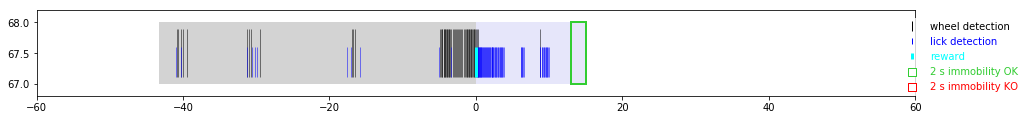

In [3]:
sessionsToPlot=["MOU101_2016_01_21_16_41"] #,"MOU101_2016_01_14_19_09","MOU101_2016_01_19_15_58"]
selectedTrials=[66]
fig=plt.figure(figsize=(cm2inch(40),cm2inch(4)))
for session,trial in zip(sessionsToPlot,selectedTrials):
    animal=session[0:6]
    data=Data(root,animal,session,paramCarola,redoPreprocess=False)
    ax=fig.add_subplot(1,1,1)
    plot_SingleTrialBehav(data,trial,legend=True,lick=True)
    #ax.set_xlim([-10,1])
    ax.axis("on")
    

Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_14_19_09/Analysis/preprocesseddata_binsize250ms_.p
15.030999999999999 15


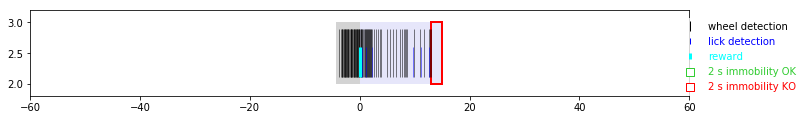

In [4]:
sessionsToPlot=["MOU101_2016_01_14_19_09"] #,"MOU101_2016_01_14_19_09","MOU101_2016_01_19_15_58"]
selectedTrials=[1]
fig=plt.figure(figsize=(cm2inch(30),cm2inch(4)))
for session,trial in zip(sessionsToPlot,selectedTrials):
    animal=session[0:6]
    data=Data(root,animal,session,paramCarola,redoPreprocess=False)
    ax=fig.add_subplot(1,1,1)
    plot_SingleTrialBehav(data,trial,legend=True,lick=True)
    #ax.set_xlim([-10,1])
    ax.axis("on")
    

## Prepare a figure with one main division

In [5]:
topVSpace=0.02
bellowVSpace=0.1
leftHSpace=0.075
rightHSpace=0.975
betweenRowSpace=0.125
nRows=1 ## this is the number of figure block in the row dimension
ratioRaws=[1]
vspaceForFig=1.0-(topVSpace+bellowVSpace+betweenRowSpace*(nRows-1))
#print("Total vertical space for figures: %s" %vspaceForFig)
topBottomLimits=[]
top=1
bottom=1
for rawNumber,rawRatio in enumerate(ratioRaws):
    vSpaceForRow=vspaceForFig*(rawRatio/np.sum(ratioRaws))
    print("raw %s size is %s" %(rawNumber+1, vSpaceForRow))
    if rawNumber==0:
        top-=topVSpace
        bottom-=topVSpace+vSpaceForRow
        print(top,bottom)
    else:
        top=bottom-betweenRowSpace
        bottom=top-vSpaceForRow
        print(top,bottom)
        print(rawNumber)
        if rawNumber==nRows-1:
            if np.round(bottom,2)!=np.round(bellowVSpace,2):
                print("last bottom does not match with required space")
    topBottomLimits.append([top,bottom])
print(topBottomLimits) 

raw 1 size is 0.88
0.98 0.09999999999999998
[[0.98, 0.09999999999999998]]


## Prepare a figure with five example trials 

Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_13_15_33/Analysis/preprocesseddata_binsize250ms_.p
15 15
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_13_15_33/Analysis/preprocesseddata_binsize250ms_.p
29.984 15
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_13_15_33/Analysis/preprocesseddata_binsize250ms_.p
53.75 15
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_19_15_58/Analysis/preprocesseddata_binsize250ms_.p
22.641 15
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_19_15_58/Analysis/preprocesseddata_binsize250ms_.p
15 15


Text(0.5,0,'Time (s)')

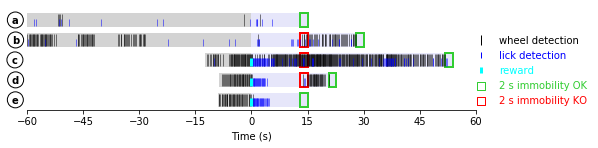

In [6]:
fig=plt.figure(figsize=(cm2inch(17.6),cm2inch(4)))
sessionsToPlot=["MOU101_2016_01_13_15_33","MOU101_2016_01_13_15_33","MOU101_2016_01_13_15_33","MOU101_2016_01_19_15_58","MOU101_2016_01_19_15_58"] #,"MOU101_2016_01_14_19_09","MOU101_2016_01_19_15_58"]
selectedTrials=[14,10,11,31,32]
legendBooleans=[False,False,False,False,True]
ylabels=['a','b','c','d','e']

bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="k", lw=1)

gs1 = gridspec.GridSpec(len(selectedTrials),1)
gs1.update(top=topBottomLimits[0][0],bottom=topBottomLimits[0][1],left=leftHSpace, right=rightHSpace, wspace=0.8,hspace=0)
subplotIndex=0
for session,trial,legendBoolean,ylabel in zip(sessionsToPlot,selectedTrials,legendBooleans,ylabels):
    animal=session[0:6]
    data=Data(root,animal,session,paramCarola,redoPreprocess=False)
    ax=fig.add_subplot(gs1[subplotIndex])
    plot_SingleTrialBehav(data,trial,legend=legendBoolean,lick=True,ax=ax)
    ax.text(-64,trial+1.5,ylabel, verticalalignment='center',horizontalalignment='left',bbox=bbox_props,fontweight='bold')
    subplotIndex+=1

ax.axis("on")
for side in ['right','top','left']:
    ax.spines[side].set_visible(False)

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelleft='off')



ax.set_xticks(np.arange(-60,61,15))
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Time (s)')

## Prepare a figure with task rule and five example trials 

Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_13_15_33/Analysis/preprocesseddata_binsize250ms_.p
15 15
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_13_15_33/Analysis/preprocesseddata_binsize250ms_.p
29.984 15
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_13_15_33/Analysis/preprocesseddata_binsize250ms_.p
53.75 15
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_19_15_58/Analysis/preprocesseddata_binsize250ms_.p
22.641 15
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_19_15_58/Analysis/preprocesseddata_binsize250ms_.p
15 15


Text(0.5,0,'Time (s)')

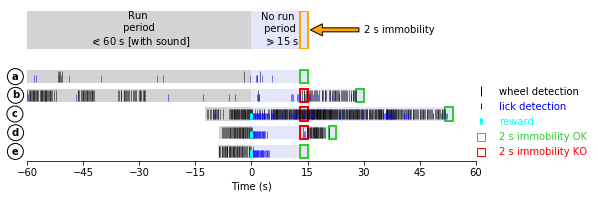

In [7]:
fig=plt.figure(figsize=(cm2inch(17.6),cm2inch(6)))
sessionsToPlot=["MOU101_2016_01_13_15_33","MOU101_2016_01_13_15_33","MOU101_2016_01_13_15_33","MOU101_2016_01_19_15_58","MOU101_2016_01_19_15_58"] #,"MOU101_2016_01_14_19_09","MOU101_2016_01_19_15_58"]
selectedTrials=[14,10,11,31,32]
legendBooleans=[False,False,False,False,True]
ylabels=['a','b','c','d','e']

bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="k", lw=1)

gs1 = gridspec.GridSpec(len(selectedTrials)+3,1)
gs1.update(top=topBottomLimits[0][0],bottom=topBottomLimits[0][1],left=leftHSpace, right=rightHSpace, wspace=0.8,hspace=0)

#create empty trial for a schematic
ax=fig.add_subplot(gs1[0:2])
ax.add_patch(Rectangle((-60,0), 60, 1, facecolor="lightgrey",edgecolor="none"))
ax.add_patch(Rectangle((0,0), 15, 1, facecolor="lavender",edgecolor="none"))
ax.add_patch(Rectangle((13,0), 2, 1, facecolor="none",edgecolor="orange",lw=2))

# ax.text(-30,0,r' $\eqslantless$ 60 s. [with sound]',va='bottom',ha='center')
ax.text(-30,0.95, 'Run \n period \n $\eqslantless$ 60 s [with sound]',va='top',ha='center')
# ax.text(7.5,0,r' $\eqslantgtr 15 s.$',va='bottom',ha='center')
ax.text(7.5,0.95,'No run \n period \n  $\eqslantgtr$ 15 s',va='top',ha='center')
ax.annotate('2 s immobility',xy=(15,0.5),xytext=(30,0.5),va='center',arrowprops=dict(facecolor='orange', shrink=0.05,width=4))
ax.set_xlim([-60,60])
ax.axis('off')        #ax.add_patch(Rectangle((0,trial+1), endInterTrial, 1, facecolor="lavender",edgecolor="none"))


# loop through illustrative trials

subplotIndex=3
for session,trial,legendBoolean,ylabel in zip(sessionsToPlot,selectedTrials,legendBooleans,ylabels):
    animal=session[0:6]
    data=Data(root,animal,session,paramCarola,redoPreprocess=False)
    ax=fig.add_subplot(gs1[subplotIndex])
    plot_SingleTrialBehav(data,trial,legend=legendBoolean,lick=True,ax=ax)
    ax.text(-64,trial+1.5,ylabel, verticalalignment='center',horizontalalignment='left',bbox=bbox_props,fontweight='bold')
    #ax.text(-64,trial+1.5,ylabel,bbox=bbox_props,fontweight='bold')
    subplotIndex+=1


# play with the last axis    
ax.axis("on")
for side in ['right','top','left']:
    ax.spines[side].set_visible(False)

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelleft='off')

ax.set_xticks(np.arange(-60,61,15))
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Time (s)')

## Prepare a figure with two divisions

In [8]:
topVSpace=0.02
bellowVSpace=0.1
leftHSpace=0.075
rightHSpace=0.7
betweenRowSpace=0.05
nRows=2 ## this is the number of figure block in the row dimension
ratioRaws=[4,3]
vspaceForFig=1.0-(topVSpace+bellowVSpace+betweenRowSpace*(nRows-1))
#print("Total vertical space for figures: %s" %vspaceForFig)
topBottomLimits=[]
top=1
bottom=1
for rawNumber,rawRatio in enumerate(ratioRaws):
    vSpaceForRow=vspaceForFig*(rawRatio/np.sum(ratioRaws))
    print("raw %s size is %s" %(rawNumber+1, vSpaceForRow))
    if rawNumber==0:
        top-=topVSpace
        bottom-=topVSpace+vSpaceForRow
        print(top,bottom)
    else:
        top=bottom-betweenRowSpace
        bottom=top-vSpaceForRow
        print(top,bottom)
        print(rawNumber)
        if rawNumber==nRows-1:
            if np.round(bottom,2)!=np.round(bellowVSpace,2):
                print("last bottom does not match with required space")
    topBottomLimits.append([top,bottom])
print(topBottomLimits) 

raw 1 size is 0.47428571428571425
0.98 0.5057142857142858
raw 2 size is 0.3557142857142857
0.4557142857142858 0.10000000000000009
1
[[0.98, 0.5057142857142858], [0.4557142857142858, 0.10000000000000009]]


## Make a figure with : 
### 1. Picture of the set up
### 2. task rule and five example trials 

Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_13_15_33/Analysis/preprocesseddata_binsize250ms_.p
15 15
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_13_15_33/Analysis/preprocesseddata_binsize250ms_.p
29.984 15
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/preprocesseddata_binsize250ms_.p
Spike data loaded from /data/MOU101/Experiments/MOU101_2016_01_21_16_41/Analysis/rawspikedata.p
15.000800000000027 15
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_13_15_33/Analysis/preprocesseddata_binsize250ms_.p
53.75 15
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_19_15_58/Analysis/preprocesseddata_binsize250ms_.p
22.641 15
Preprocess behavior data loaded from /data/MOU101/Experiments/MOU101_2016_01_19_15_58/Analysis/preprocesseddata_binsize250ms_.p
15 15


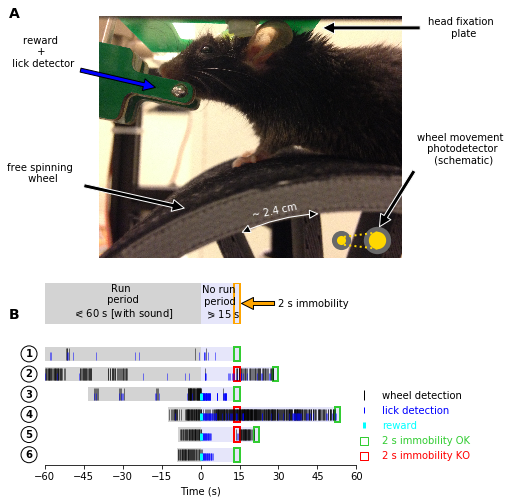

In [11]:
fig=plt.figure(figsize=(cm2inch(17.6),cm2inch(18)))

sessionsToPlot=["MOU101_2016_01_13_15_33","MOU101_2016_01_13_15_33","MOU101_2016_01_21_16_41","MOU101_2016_01_13_15_33","MOU101_2016_01_19_15_58","MOU101_2016_01_19_15_58"] #,"MOU101_2016_01_14_19_09","MOU101_2016_01_19_15_58"]
selectedTrials=[14,10,66,11,31,32]
legendBooleans=[False,False,False,False,False,True]
ylabels=['a','b','c','d','e','f']
ylabels=['1','2','3','4','5','6']
bbox_props = dict(boxstyle="circle", fc="w", ec="k", lw=1)
picFileName='IMG_0387.jpg'
pathPicFileNames=os.path.join(root,"ALLMOU_Analysis",picFileName)

for index,topBottomLimit in enumerate(topBottomLimits):
    if index==0:  ## panel A
        gs2 = gridspec.GridSpec(1,1)
        gs2.update(top=topBottomLimit[0],bottom=topBottomLimit[1],left=leftHSpace, right=rightHSpace, wspace=0.3,hspace=0.5)
        ax1=fig.add_subplot(gs2[0])
        im = plt.imread(pathPicFileNames)
        ax1.imshow(im)
        ax1.set_xlim([500,3000])
        ax1.set_ylim([2400,400])
        ax1.annotate('reward \n + \n lick detector',xy=(1000,1000),xytext=(25,700),va='center',arrowprops=dict(facecolor='blue', shrink=0.05,width=4),ha='center')
        ax1.annotate('free spinning \n wheel',xy=(1250,2000),xytext=(25,1700),va='center',arrowprops=dict(facecolor='black',edgecolor='white', shrink=0.05,width=4),ha='center')
        ax1.annotate('head fixation \n plate',xy=(2300,500),xytext=(3500,500),va='center',arrowprops=dict(facecolor='black',edgecolor='white', shrink=0.05,width=4),ha='center')
        ax1.scatter(2500,2250,s=200,edgecolor='dimgray',linewidth=5,facecolor='gold')
        ax1.plot([2800,2500],[2325,2290],':',color='gold',linewidth=2)
        ax1.plot([2800,2500],[2190,2230],':',color='gold',linewidth=2)
        ax1.scatter(2800,2250,s=500,edgecolor='dimgrey',linewidth=5,facecolor='gold')
        ax1.annotate('wheel movement \n photodetector \n (schematic)',xy=(2800,2170),xytext=(3500,1500),va='center',arrowprops=dict(facecolor='black',edgecolor='white', shrink=0.05,width=4),ha='center')
        ax1.add_patch(FancyArrowPatch((1660, 2200),(2330,2035), arrowstyle='<|-|>',linewidth=1, connectionstyle='arc3, rad=-0.1',mutation_scale=20,edgecolor='w',facecolor='k'))
        ax1.annotate('~ 2.4 cm',xy=(1950,2000),color='w',ha='center',rotation=12)
        pos1 = ax1.get_position() # get the original position 
        pos2 = [pos1.x0 + 0.1, pos1.y0,pos1.width, pos1.height] 
        ax1.set_position(pos2)
        
        ax1.axis("off")
    
    
        #ax1.set_yticklabels([])
        
    else:
        gs1 = gridspec.GridSpec(len(selectedTrials)+3,1)
        gs1.update(top=topBottomLimit[0],bottom=topBottomLimit[1],left=leftHSpace, right=rightHSpace, wspace=0.8,hspace=0)

        #create empty trial for a schematic
        ax=fig.add_subplot(gs1[0:2])
        ax.add_patch(Rectangle((-60,0), 60, 1, facecolor="lightgrey",edgecolor="none"))
        ax.add_patch(Rectangle((0,0), 15, 1, facecolor="lavender",edgecolor="none"))
        ax.add_patch(Rectangle((13,0), 2, 1, facecolor="none",edgecolor="orange",lw=2))

        # ax.text(-30,0,r' $\eqslantless$ 60 s. [with sound]',va='bottom',ha='center')
        ax.text(-30,0.95, 'Run \n period \n $\eqslantless$ 60 s [with sound]',va='top',ha='center')
        # ax.text(7.5,0,r' $\eqslantgtr 15 s.$',va='bottom',ha='center')
        ax.text(7.5,0.95,'No run \n period \n  $\eqslantgtr$ 15 s',va='top',ha='center')
        ax.annotate('2 s immobility',xy=(15,0.5),xytext=(30,0.5),va='center',arrowprops=dict(facecolor='orange', shrink=0.05,width=4))
        ax.set_xlim([-60,60])
        ax.axis('off')        #ax.add_patch(Rectangle((0,trial+1), endInterTrial, 1, facecolor="lavender",edgecolor="none"))


        # loop through illustrative trials

        subplotIndex=3
        for session,trial,legendBoolean,ylabel in zip(sessionsToPlot,selectedTrials,legendBooleans,ylabels):
            animal=session[0:6]
            data=Data(root,animal,session,paramCarola,redoPreprocess=False)
            ax=fig.add_subplot(gs1[subplotIndex])
            plot_SingleTrialBehav(data,trial,legend=legendBoolean,lick=True,ax=ax)
            ax.text(-66,trial+1.5,ylabel, verticalalignment='center',horizontalalignment='center',bbox=bbox_props,fontweight='bold')
            subplotIndex+=1


        # play with the last axis    
        ax.axis("on")
        for side in ['right','top','left']:
            ax.spines[side].set_visible(False)

        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='off')

        ax.set_xticks(np.arange(-60,61,15))
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('Time (s)')
        
        
        
FiguresLabels={"A":[0.025,0.97],"B":[0.025,0.38]}
for Label,coordinates in sorted(FiguresLabels.items()):
    fig.text(coordinates[0],coordinates[1],Label,figure=fig,weight='bold',fontsize=14,ha='right' ,va='bottom')
    
    
# trialLabels=['(1)','(2)','(3)','(4)','(5)','(6)']
# firstCoordinates=[0.037,0.31]
# for trialLabel in sorted(trialLabels):
#     fig.text(firstCoordinates[0],firstCoordinates[1],trialLabel,figure=fig,fontsize=12,weight='bold',ha='right' ,va='center')
#     firstCoordinates[1]-=0.04


SaveFullName=os.path.join(pathToSaveFig,'RevisedFigS01_ApparatusTask.pdf')
fig.savefig(SaveFullName,orientation='landscape',dpi=600,format='pdf')    
#fig.show()

**Figure S1. Training apparatus, task structure and illustrative trials. A)** Head-fixed mice are running
for liquid reward (drops of a sucrose solution) on a free spinning wheel. Rewards are delivered in front of the animal mouth and licks are detected with a photodetector. Movements of the wheel are detected when its spokes crossed a photodetector. The distance between spokes detections is about 2.4 cm. **B)** Task structure (top) and illustrative trials (real data taken from 3 different sessions of a single animal, bottom).